# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

import random
import scipy.sparse as sparse

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/calculation/.local/lib/python3.6/site-packages/tensorflow/python/frame

# 2. Loading data

In [2]:
percentage=5
Training_samples=600*percentage
Testing_samples=4000

(x_train_, y_train_), (x_test_, y_test_) = fashion_mnist.load_data()
x_train = x_train_.reshape(60000, 28*28).astype('float32')[0:Training_samples] / 255.
x_test__ = x_test_.reshape(10000, 28*28).astype('float32') / 255.

np.random.seed(seed)
x_test__num,_=x_test__.shape
index=np.arange(x_test__num)
np.random.shuffle(index)

x_test=x_test__[index][0:Testing_samples]

y_train=y_train_[0:Training_samples]
y_test=y_test_[index][0:Testing_samples]

y_train_onehot_ = np.array(y_train)
y_test_onehot_ = np.array(y_test)

y_train_onehot = to_categorical(y_train_onehot_)
y_test_onehot = to_categorical(y_test_onehot_)

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train_onehot.shape))
print('Shape of y_test: ' + str(y_test_onehot.shape))

x_train_=np.transpose(x_train)
x_test_=np.transpose(x_test)
print('Shape of x_train_: ' + str(x_train_.shape)) 
print('Shape of x_test_: ' + str(x_test_.shape))

Shape of x_train: (3000, 784)
Shape of x_test: (4000, 784)
Shape of y_train: (3000, 10)
Shape of y_test: (4000, 10)
Shape of x_train_: (784, 3000)
Shape of x_test_: (784, 4000)


In [3]:
sample_number=50

# 3.Model

In [4]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, l1_lambda, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.l1_lambda=l1_lambda

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0.999999, maxval=0.9999999, seed=seed),
                                      trainable=True,
                                      regularizer=regularizers.l1(self.l1_lambda),
                                      constraint=constraints.NonNeg())
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=sample_number):
        kernel=self.kernel        
        if selection:
            kernel_=K.transpose(kernel)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Autoencoder(p_data_feature=x_train_.shape[1],\
                p_data_feature_=x_test_.shape[1],\
                p_encoding_dim=sample_number,\
                p_learning_rate= 1E-3):
    input_img = Input(shape=(p_data_feature,), name='input_img')

    encoded = Dense(p_encoding_dim, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(input_img)
    bottleneck=encoded
    decoded = Dense(p_data_feature_, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(encoded)

    latent_encoder = Model(input_img, bottleneck)
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    #print('Latent Encoder Structure-------------------------------------')
    #latent_encoder.summary()
    return autoencoder,latent_encoder

#--------------------------------------------------------------------------------------------------------------------------------
def Identity_Autoencoder(p_data_feature=x_train_.shape[1],\
                         p_encoding_dim=sample_number,\
                         p_learning_rate= 1E-3,\
                         p_l1_lambda=0.1):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    
    bottleneck_score=encoded_score
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)

    latent_encoder_score = Model(input_img, bottleneck_score)
    autoencoder = Model(input_img, decoded_score)
    
    autoencoder.compile(loss='mean_squared_error',\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,latent_encoder_score

#--------------------------------------------------------------------------------------------------------------------------------
def Fractal_Autoencoder(p_data_feature=x_train_.shape[1],\
                        p_feture_number=sample_number,\
                        p_encoding_dim=sample_number,\
                        p_learning_rate=1E-3,\
                        p_l1_lambda=0.1,\
                        p_loss_weight_1=1,\
                        p_loss_weight_2=2):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)
    feature_selection_choose=feature_selection(input_img,selection=True,k=p_feture_number)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    encoded_choose=encoded(feature_selection_choose)
    
    bottleneck_score=encoded_score
    bottleneck_choose=encoded_choose
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)
    decoded_choose =decoded(bottleneck_choose)

    latent_encoder_score = Model(input_img, bottleneck_score)
    latent_encoder_choose = Model(input_img, bottleneck_choose)
    feature_selection_output=Model(input_img,feature_selection_choose)
    autoencoder = Model(input_img, [decoded_score,decoded_choose])
    
    autoencoder.compile(loss=['mean_squared_error','mean_squared_error'],\
                        loss_weights=[p_loss_weight_1, p_loss_weight_2],\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,feature_selection_output,latent_encoder_score,latent_encoder_choose

## 3.1 Structure and paramter testing

In [5]:
epochs_number=200
batch_size_value=256

---
### 3.1.1 Fractal Autoencoder
---

In [6]:
F_AE,\
feature_selection_output,\
latent_encoder_score_F_AE,\
latent_encoder_choose_F_AE=Fractal_Autoencoder(p_data_feature=x_train_.shape[1],\
                                               p_feture_number=sample_number,\
                                               p_encoding_dim=sample_number,\
                                               p_learning_rate= 1E-3,\
                                               p_l1_lambda=0.1,\
                                               p_loss_weight_1=1,\
                                               p_loss_weight_2=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Autoencoder Structure-------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 3000)         0                                            
__________________________________________________________________________________________________
feature_selection (Feature_Sele (None, 3000)         3000        autoencoder_input[0][0]          
                                                                 autoencoder_input[0][0]          
__________________________________________________________________________________________________
autoencoder_hidden_layer (Dense (None, 50)           150050      feature_selection[0][0]          
                                      

In [7]:
File_name='./log_weights/F_AE_'+str(percentage)+'_'+str(sample_number)+'_weights.MNIST0200.hdf5'

In [8]:
F_AE.load_weights(File_name, by_name=True)
weights_feature_selection_layer=F_AE.get_layer(index=1).get_weights()[0]
print(np.sum(weights_feature_selection_layer>0))

3000


In [9]:
key_features_1=F.top_k_keepWeights_1(F_AE.get_layer(index=1).get_weights()[0],sample_number)

In [10]:
choose_sample_index=np.where(key_features_1==1)

In [11]:
_x_train_=x_train_[:,choose_sample_index[0]]

In [12]:
x_test_.shape

(784, 4000)

In [13]:
AE,\
latent_encoder=Autoencoder(p_data_feature=_x_train_.shape[1],\
                           p_encoding_dim=sample_number,\
                           p_learning_rate= 1E-3)

Autoencoder Structure-------------------------------------
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 4000)              204000    
Total params: 206,550
Trainable params: 206,550
Non-trainable params: 0
_________________________________________________________________


In [14]:
AE_history = AE.fit(_x_train_, x_test_,\
                    epochs=epochs_number,\
                    batch_size=batch_size_value,\
                    shuffle=True)


Epoch 1/200
784/784 [==============================] - 0s 378us/step - loss: 0.2046
Epoch 2/200
784/784 [==============================] - 0s 172us/step - loss: 0.1635
Epoch 3/200
784/784 [==============================] - 0s 159us/step - loss: 0.1206
Epoch 4/200
784/784 [==============================] - 0s 172us/step - loss: 0.0881
Epoch 5/200
784/784 [==============================] - 0s 183us/step - loss: 0.0744
Epoch 6/200
784/784 [==============================] - 0s 185us/step - loss: 0.0719
Epoch 7/200
784/784 [==============================] - 0s 188us/step - loss: 0.0670
Epoch 8/200
784/784 [==============================] - 0s 172us/step - loss: 0.0621
Epoch 9/200
784/784 [==============================] - 0s 156us/step - loss: 0.0596
Epoch 10/200
784/784 [==============================] - 0s 166us/step - loss: 0.0577
Epoch 11/200
784/784 [==============================] - 0s 151us/step - loss: 0.0552
Epoch 12/200
784/784 [==============================] - 0s 165us/step - l

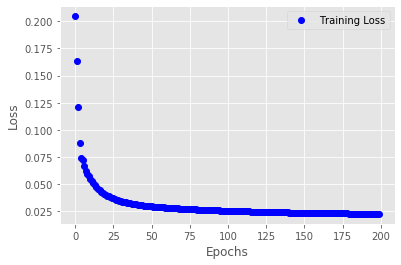

In [15]:
loss = AE_history.history['loss']

epochs = range(epochs_number)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
p_data=AE.predict(_x_train_)
numbers=x_test_.shape[0]*x_test_.shape[1]

print("MSE",np.sum(np.power(np.array(p_data)-x_test_,2))/numbers)

MSE 0.022675320372289542


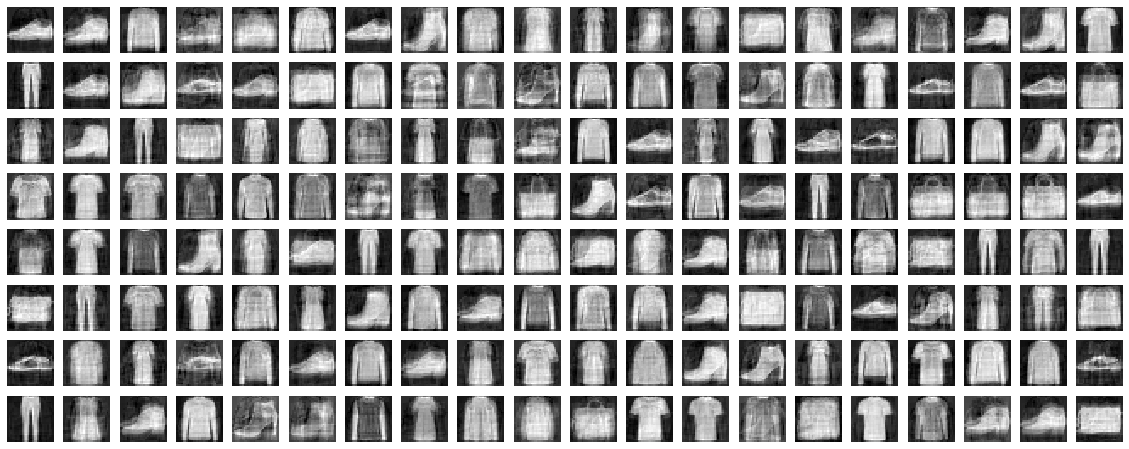

In [17]:
F.show_data_figures(np.transpose(p_data)[0:160],w=28,h=28,columns = 20)

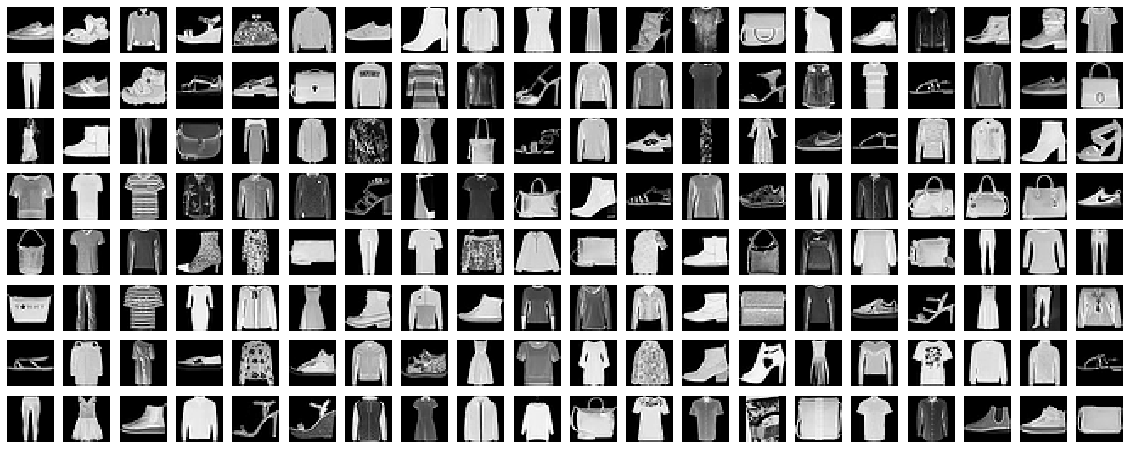

In [18]:
F.show_data_figures(np.transpose(x_test_)[0:160],w=28,h=28,columns = 20)

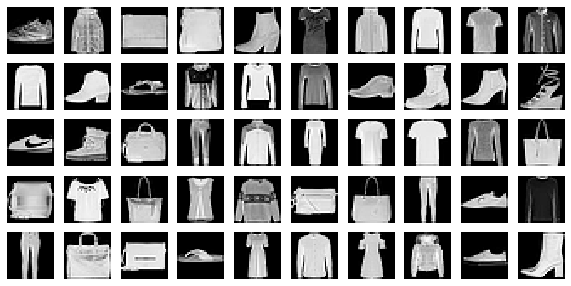

In [19]:
F.show_data_figures(np.transpose(_x_train_),w=28,h=28,columns = 10)